In [1]:
import numpy as np
import pandas as pd
import os

import re
from datetime import datetime as time
from ast import literal_eval
from sklearn.model_selection import train_test_split

import artm
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import gc
import matplotlib.pyplot as plt
%matplotlib inline

/home/vtrokhymenko/proj_news_viz/env4news/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [3]:
!ls -lah data/*.csv.bz2

-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 491K Jan 15 18:18 data/69-.paralel.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  48M Jan 15 18:21 data/Russia.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  12M Jan 15 18:21 data/Sil_struktur.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  44K Jan 15 18:19 data/biblioteka.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  25M Jan 15 18:19 data/bivs.SSR.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 6.1M Jan 15 18:18 data/biznes.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 2.9M Jan 15 18:21 data/cennosti.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  28M Jan 15 18:21 data/economic.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  16M Jan 15 18:19 data/internet.i.smi.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 8.6M Jan 15 18:18 data/iz.jizni.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 125K Jan 15 18:18 data/kultprosvet.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  20M Jan 15 18:18 data/kultura.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 

In [2]:
artm.version()

'0.9.0'

In [3]:
name_dataset = 'sport'

### load data

In [4]:
%%time
df = pd.read_csv(f'data/{name_dataset}.csv.bz2')
print(df.shape)

(60849, 7)
CPU times: user 6.89 s, sys: 131 ms, total: 7.02 s
Wall time: 7.05 s


In [5]:
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic
0,1999-10-08 12:00:00,https://lenta.ru/news/1999/10/08/boxing/,NaN,Мир,Дочь Мухаммеда Али дебютирует на ринге,"Лейла Али, дочь известного боксера-тяжеловеса ...",Спорт
1,1999-10-09 12:00:00,https://lenta.ru/news/1999/10/09/football/,NaN,Россия,"Россия — Украина: ничья 1:1, Франция выиграла ...",В субботу 9 октября на Большой спортивной арен...,Спорт


### preprocess

* get dates

In [6]:
%%time

df['date_raw'] = df['url'].apply(re.compile('(\d{4})/(\d{2})/(\d{2})').findall)

df['year'] = df['date_raw'].apply(lambda x: int(x[0][0]))
df['month'] = df['date_raw'].apply(lambda x: int(x[0][1]))

CPU times: user 236 ms, sys: 10.8 ms, total: 247 ms
Wall time: 246 ms


<unknown>:2: DeprecationWarning: invalid escape sequence \d


* clean text

In [8]:
import preprocessing_tools as pr

In [9]:
%%time
df.text = df.text.apply(pr.clean_text)

CPU times: user 8.15 s, sys: 55 ms, total: 8.2 s
Wall time: 8.2 s


In [10]:
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic,date_raw,year,month
0,1999-10-08 12:00:00,https://lenta.ru/news/1999/10/08/boxing/,NaN,Мир,Дочь Мухаммеда Али дебютирует на ринге,лейла али дочь известного боксератяжеловеса му...,Спорт,"[(1999, 10, 08)]",1999,10
1,1999-10-09 12:00:00,https://lenta.ru/news/1999/10/09/football/,NaN,Россия,"Россия — Украина: ничья 1:1, Франция выиграла ...",в субботу октября на большой спортивной арене...,Спорт,"[(1999, 10, 09)]",1999,10


* cleanedNames

In [11]:
from cleanedNames import KeyProc
cn = KeyProc()

In [12]:
%%time
df.text = df.text.apply(cn.replaceKeywords)

CPU times: user 1min 23s, sys: 1.48 ms, total: 1min 23s
Wall time: 1min 23s


* lemmatization

In [13]:
%%time
df['lemmatized_text'] = df.text.apply(pr.lemmatization)

CPU times: user 2min 14s, sys: 172 ms, total: 2min 14s
Wall time: 2min 14s


* add docID

In [14]:
df['docID'] = list(range(df.shape[0]))

In [15]:
df = df[['docID','year','month','lemmatized_text']]
df.head(2)

,docID,year,month,lemmatized_text
0,0,1999,10,"[лейла, али, дочь, известный, боксератяжеловес..."
1,1,1999,10,"[большой, спортивный, арен, московский, стадио..."


In [16]:
print(df.shape)
df.isnull().sum()

(60849, 4)


docID              0
year               0
month              0
lemmatized_text    0
dtype: int64

In [17]:
df.year.min()

1999

## model

* prepare

In [18]:
%%time

vwpath = f'data/vwpath/{name_dataset}_input_bigartm.vw'

with open(vwpath, 'w') as fp:
    for text, did in df[['lemmatized_text', 'docID']].values:
        fp.write('{} | {}\n'.format(did, ' '.join(text)))

CPU times: user 592 ms, sys: 100 ms, total: 692 ms
Wall time: 741 ms


In [19]:
df.head()

,docID,year,month,lemmatized_text
0,0,1999,10,"[лейла, али, дочь, известный, боксератяжеловес..."
1,1,1999,10,"[большой, спортивный, арен, московский, стадио..."
2,2,1999,10,"[известно, клуб, футбольный, премьерлига, англ..."
3,3,1999,10,"[times, воскресение, блистательный, победа, ко..."
4,4,1999,12,"[франкфуртенамайн, завершиться, очередной, рау..."


In [20]:
for text, did in df[['lemmatized_text', 'docID']].values[:2]:
    print(' '.join(text),did)

лейла али дочь известный боксератяжеловес мухаммед али дебютировать бизнес известный отец профессиональный бой лейла состояться казино turning stone верона штат ньюйорк назначить следующий бой лейла собираться отправить нокаут лейла прозвище мадам батерфляй иметь вид соперница летний эприл фаулера четыре раунд бой правда bbc бой транислироваться телевидение записываться видео просьба лейла нервничать шоу свидетельство устроитель собраться около журналист свет лейла мать вероника жена мухаммед али прийти посмотреть дебютный выступление юный боксёрш прийти ли_ный шоу отец неизвестно проработать ринг страдать болезнь паркинсон мухаммед али отрицательно относиться решение дочь заняться профессиональный бокс соперница лейла летний эприл фаулера очередь уверить победа бояться лейла громкий фамилия али просто фамилия драться отец ринг эприл 0
большой спортивный арен московский стадион лужники проходить матч футбольный сборный россия украина тайм нулевой счёт минута матч счёт открыть игрок рос

In [21]:
id_date = df[['docID', 'year', 'month']].copy()

* collect batchs and collect the dictionary

In [22]:
%%time

batches_path = f'data/batches/{name_dataset}'

if not os.path.exists(batches_path):
    print('create folder...\n')
    os.makedirs(batches_path)
    
batch_vectorizer = artm.BatchVectorizer(data_path=vwpath,
                                        data_format='vowpal_wabbit',
                                        target_folder=batches_path)

print(batch_vectorizer)

artm.BatchVectorizer(data_path="data/batches/sport", num_batches=61)
CPU times: user 22.1 s, sys: 665 ms, total: 22.7 s
Wall time: 5.66 s


In [23]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=batches_path)

In [24]:
dictionary.filter(min_tf=10, max_df_rate=0.1) #int(4.5e5)

artm.Dictionary(name=968fc70f-a9e6-47d6-9f3c-61958c03e8cb, num_entries=21723)

In [146]:
dictionary.save_text(f'data/dicts/dict_{name_dataset}.txt')

## pick up amount topics

In [281]:
%%time
model_list = []
step, perplexity, sTheta, sPhi = [], [], [], []

for i in range(2,20+1,1):
    print(f'#topic {i}.........')
    step.append(i)
    date_start = time.now()
    
    num_topics = i
    model = artm.ARTM(num_topics=num_topics, dictionary=dictionary)
    
    # scores
    model.scores.add(artm.PerplexityScore(name='PerplexityScore',dictionary=dictionary))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

    # regularizers
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
    model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
    
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=50)
    model_list.append(model)
    
    sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
    sTheta.append(sparsityTheta)
    sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
    sPhi.append(sparsityPhi)
    perpl = model.score_tracker['PerplexityScore'].last_value
    perplexity.append(perpl)
    
    print(f'\tSparsityThetaScore: {sparsityTheta}')
    print(f'\tSparsityPhiScore: {sparsityPhi}')
    print(f'\tPerplexityScore: {perpl}')
    
    print('\ttime:',time.now()-date_start)
    
newTime = time.now() #

#topic 2.........
	SparsityThetaScore: 0.14394648373126984
	SparsityPhiScore: 0.3168881833553314
	PerplexityScore: 3844.85546875
	time: 0:00:26.727798
#topic 3.........
	SparsityThetaScore: 0.3128618896007538
	SparsityPhiScore: 0.4279407262802124
	PerplexityScore: 3266.755126953125
	time: 0:00:27.963084
#topic 4.........
	SparsityThetaScore: 0.47226741909980774
	SparsityPhiScore: 0.5142186284065247
	PerplexityScore: 2883.92431640625
	time: 0:00:28.637152
#topic 5.........
	SparsityThetaScore: 0.5518217086791992
	SparsityPhiScore: 0.5772044062614441
	PerplexityScore: 2650.1103515625
	time: 0:00:29.600335
#topic 6.........
	SparsityThetaScore: 0.5685713887214661
	SparsityPhiScore: 0.6184310913085938
	PerplexityScore: 2466.820556640625
	time: 0:00:30.302173
#topic 7.........
	SparsityThetaScore: 0.5826718807220459
	SparsityPhiScore: 0.6559643745422363
	PerplexityScore: 2375.656494140625
	time: 0:00:32.660598
#topic 8.........
	SparsityThetaScore: 0.6183832287788391
	SparsityPhiScore: 0.68

In [353]:
model_list

[artm.ARTM(num_topics=2, num_tokens=21820),
 artm.ARTM(num_topics=3, num_tokens=21820),
 artm.ARTM(num_topics=4, num_tokens=21820),
 artm.ARTM(num_topics=5, num_tokens=21820),
 artm.ARTM(num_topics=6, num_tokens=21820),
 artm.ARTM(num_topics=7, num_tokens=21820),
 artm.ARTM(num_topics=8, num_tokens=21820),
 artm.ARTM(num_topics=9, num_tokens=21820),
 artm.ARTM(num_topics=10, num_tokens=21820),
 artm.ARTM(num_topics=11, num_tokens=21820),
 artm.ARTM(num_topics=12, num_tokens=21820),
 artm.ARTM(num_topics=13, num_tokens=21820),
 artm.ARTM(num_topics=14, num_tokens=21820),
 artm.ARTM(num_topics=15, num_tokens=21820),
 artm.ARTM(num_topics=16, num_tokens=21820),
 artm.ARTM(num_topics=17, num_tokens=21820),
 artm.ARTM(num_topics=18, num_tokens=21820),
 artm.ARTM(num_topics=19, num_tokens=21820),
 artm.ARTM(num_topics=20, num_tokens=21820)]

Text(0.5, 1.0, 'SparsityPhiScore')

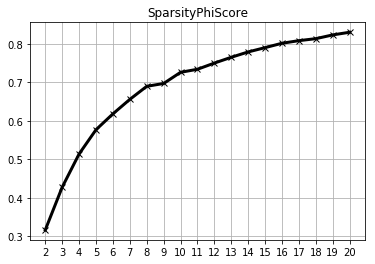

In [296]:
plt.plot(step, sPhi, color='k',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('SparsityPhiScore')

In [422]:
index_sphi = []
[index_sphi.append(float(str(i)[:3]) ) for i in sPhi]
    
index_sphi = list(set(index_sphi))
index_sphi.sort()
index_sphi

[0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

In [423]:
d_sphi = {}

for j in range(len(index_sphi)):
    k=0
    for i in sPhi:
        if j==range(len(index_sphi))[-1]:
            if (i>=index_sphi[j]):
                k+=1
        else:
            if (i>=index_sphi[j]) & (i<index_sphi[j+1]):
                k+=1
    d_sphi[index_sphi[j]]=k

d_sphi

{0.3: 1, 0.4: 1, 0.5: 2, 0.6: 4, 0.7: 6, 0.8: 5}

Text(0.5, 1.0, 'SparsityThetaScore')

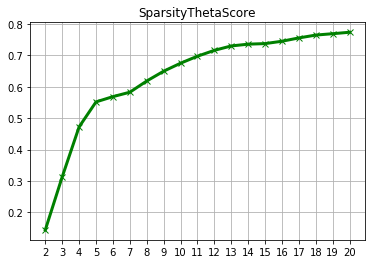

In [424]:
plt.plot(step, sTheta, color='g',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()

plt.title('SparsityThetaScore')

In [425]:
index_theta = []
[index_theta.append(float(str(i)[:3])) for i in sTheta]
    
index_theta = list(set(index_theta))
index_theta.sort()
index_theta

[0.1, 0.3, 0.4, 0.5, 0.6, 0.7]

In [427]:
d_stheta = {}

for j in range(len(index_theta)):
    k=0
    for i in sTheta:
        if j==range(len(index_theta))[-1]:
            if (i>=index_theta[j]):
                k+=1
        else:
            if (i>=index_theta[j]) & (i<index_theta[j+1]):
                k+=1
    d_stheta[index_theta[j]]=k

d_stheta

{0.1: 1, 0.3: 1, 0.4: 1, 0.5: 3, 0.6: 4, 0.7: 9}

Text(0.5, 1.0, 'PerplexityScore')

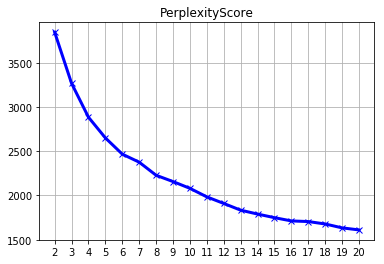

In [428]:
plt.plot(step, perplexity, color='b',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('PerplexityScore')

In [431]:
perplexity

[3844.85546875,
 3266.755126953125,
 2883.92431640625,
 2650.1103515625,
 2466.820556640625,
 2375.656494140625,
 2227.826416015625,
 2156.648193359375,
 2080.157470703125,
 1983.6279296875,
 1909.3548583984375,
 1833.3291015625,
 1789.39990234375,
 1748.635986328125,
 1711.8211669921875,
 1704.6588134765625,
 1677.3221435546875,
 1633.2545166015625,
 1610.190185546875]

### select the best model

In [434]:
select_topics = 20 # u should choose number of topic

best_model = model_list[select_topics-2]
print(best_model.num_topics)

20


----

In [28]:
select_topics = 20

model = artm.ARTM(num_topics=select_topics, dictionary=dictionary, show_progress_bars=True)

# scores
model.scores.add(artm.PerplexityScore(name='PerplexityScore',dictionary=dictionary))
model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

# regularizers
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))

model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=50)

sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
perpl = model.score_tracker['PerplexityScore'].last_value

print(f'\tSparsityThetaScore: {sparsityTheta}')
print(f'\tSparsityPhiScore: {sparsityPhi}')
print(f'\tPerplexityScore: {perpl}')

best_model = model.clone()


	SparsityThetaScore: 0.7789199352264404
	SparsityPhiScore: 0.8280255794525146
	PerplexityScore: 1577.3592529296875


---

### print top words for each topics

In [30]:
phi = best_model.get_phi()
phi['word'] = phi.index
#phi.head()

for col in phi.columns:
    if col != 'word':
        print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")
        #print('\t',phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10])

topic_0: ['спартак' 'цска' 'зенит' 'локомотив' 'динамо' 'полузащитник' 'рубин'
 'армеец' 'премьерлига' 'москва']
topic_1: ['челси' 'манчестер' 'английский' 'англия' 'миллион' 'юнайтед'
 'лондонский' 'евро' 'милан' 'арсенал']
topic_2: ['германия' 'отборочный' 'евро' 'франция' 'групповой' 'чм' 'этап'
 'португалия' 'италия' 'англия']
topic_3: ['нхл' 'шайба' 'передача' 'нба' 'забросить' 'серия' 'регулярный'
 'вашингтон' 'результативный' 'очко']
topic_4: ['реал' 'барселона' 'испания' 'испанский' 'мадридский' 'бразилия'
 'бавария' 'бразильский' 'бразилец' 'аргентина']
topic_5: ['миллион' 'доллар' 'тысяча' 'стадион' 'украина' 'сумма' 'рубль' 'деньга'
 'украинский' 'москва']
topic_6: ['бывший' 'автомобиль' 'дом' 'смерть' 'twitter' 'скончаться' 'произойти'
 'ребёнок' 'жизнь' 'видео']
topic_7: ['хоккей' 'кхл' 'хоккеист' 'хоккейный' 'шайба' 'период' 'металлург' 'ска'
 'авангард' 'забросить']
topic_8: ['болельщик' 'фанат' 'арбитр' 'стадион' 'инцидент' 'произойти' 'судья'
 'тысяча' 'драка' 'билет']

In [42]:
# save to json

outjson = {}
# ---
phi = best_model.get_phi()
phi['word'] = phi.index
#phi.head()

for col in phi.columns:
    if col != 'word':
        #print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")
        #print('\t',phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10])
        outjson[f'{col}'] = phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:20]

In [43]:
import pickle

with open(f'''data/top20word/{'-'.join(name_dataset.split('.'))}.pickle''', 'wb') as handle:
    pickle.dump(outjson, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [44]:
with open(f'''data/top20word/{'-'.join(name_dataset.split('.'))}.pickle''', 'rb') as handle:
    out_picle = pickle.load(handle)
    
out_picle

{'topic_0': array(['спартак', 'цска', 'зенит', 'локомотив', 'динамо', 'полузащитник',
        'рубин', 'армеец', 'премьерлига', 'москва', 'анжи', 'питерский',
        'таблица', 'го', 'ростов', 'крыло', 'терек', 'турнирный', 'пол',
        'совет'], dtype=object),
 'topic_1': array(['челси', 'манчестер', 'английский', 'англия', 'миллион', 'юнайтед',
        'лондонский', 'евро', 'милан', 'арсенал', 'итальянский', 'италия',
        'полузащитник', 'интер', 'ливерпуль', 'ювентус', 'сити', 'фунт',
        'перейти', 'мю'], dtype=object),
 'topic_2': array(['германия', 'отборочный', 'евро', 'франция', 'групповой', 'чм',
        'этап', 'португалия', 'италия', 'англия', 'товарищеский',
        'хорватия', 'испания', 'уефа', 'финальный', 'фифа', 'рейтинг',
        'попасть', 'греция', 'европейский'], dtype=object),
 'topic_3': array(['нхл', 'шайба', 'передача', 'нба', 'забросить', 'серия',
        'регулярный', 'вашингтон', 'результативный', 'очко', 'ночь',
        'хоккеист', 'питтсбург', '

### get topics-docs matrix

shape theta: (20, 60849)


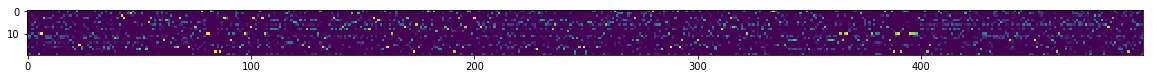

In [31]:
theta = best_model.transform_sparse(batch_vectorizer=batch_vectorizer, eps=0.001)
print(f'shape theta: {theta[0].shape}')

plt.figure(figsize=(20, 20))
plt.imshow(theta[0][:, 2000:2500].toarray());

### dense theta matrix

In [32]:
theta = best_model.transform(batch_vectorizer=batch_vectorizer)
theta = theta.T
theta.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
43000,0.0,0.0,0.03637,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.467547,0.0,0.000000,0.0,0.0,0.496084,0.0,0.0
43001,0.0,0.0,0.03711,0.000000,0.0,0.024783,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.412463,0.0,0.000000,0.0,0.0,0.525644,0.0,0.0
43002,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.181270,0.000000,0.033308,0.0,0.0,0.000000,0.520376,0.0,0.000000,0.0,0.0,0.265046,0.0,0.0
43003,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.027357,0.000000,0.000000,0.0,0.0,0.000000,0.550709,0.0,0.000000,0.0,0.0,0.421934,0.0,0.0
43004,0.0,0.0,0.00000,0.124008,0.0,0.162798,0.000000,0.262177,0.000000,0.0,0.0,0.135844,0.000000,0.0,0.315174,0.0,0.0,0.000000,0.0,0.0


## DataViz

In [33]:
joined = id_date.join(theta)
joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,1999,10,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.324457,...,0.310229,0.133554,0.000000,0.031726,0.200034,0.000000,0.0,0.000000,0.000000,0.0
1,1,1999,10,0.017693,0.000000,0.242693,0.0,0.000000,0.145671,0.000000,...,0.000000,0.000000,0.107085,0.000000,0.000000,0.322927,0.0,0.000000,0.000000,0.0
2,2,1999,10,0.000000,0.282228,0.000000,0.0,0.028531,0.311935,0.217573,...,0.000000,0.048362,0.110676,0.000000,0.000695,0.000000,0.0,0.000000,0.000000,0.0
3,3,1999,10,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.068380,0.132985,0.000000,0.016713,0.000000,0.0,0.121322,0.561363,0.0
4,4,1999,12,0.000000,0.087762,0.000000,0.0,0.000000,0.236211,0.000000,...,0.106635,0.000000,0.262116,0.000000,0.272139,0.000000,0.0,0.000000,0.000000,0.0


In [34]:
topics = ['topic_{}'.format(i) for i in range(select_topics)]
gb = joined.groupby(['year', 'month'])[topics].sum()
print(f'gb.shape: {gb.shape}')
gb.head()

gb.shape: (227, 20)


topic_0   topic_1   topic_2   topic_3   topic_4   topic_5  \
year month                                                               
1999 9      0.043734  0.068251  0.004964  0.000000  0.141444  0.514210   
     10     0.017693  0.282228  0.242693  0.000000  0.028531  0.457606   
     11     0.000000  0.000000  0.000000  0.054018  0.000000  0.467205   
     12     0.000000  0.094225  0.000000  0.000000  0.000000  0.258505   
2000 1      0.138949  0.051117  0.074113  0.016941  0.000000  0.530490   

             topic_6   topic_7   topic_8   topic_9  topic_10  topic_11  \
year month                                                               
1999 9      1.027547  0.188427  1.100373  0.009014  0.000000  0.264183   
     10     0.542030  0.000000  0.163930  0.099237  0.310229  0.250297   
     11     0.964128  0.000000  0.350748  0.019564  0.038962  0.268249   
     12     0.000000  0.000000  0.000000  0.035137  0.106635  0.000000   
2000 1      0.480568  0.008993  1.384802  0.000000  0.000000  0.646425   

            topic_12  topic_13  topic_14  topic_15  topic_16  topic_17  \
year month                                                               
1999 9      0.483303  0.000000  0.085663  0.000000  0.000000  0.040609   
     10     0.350745  0.031726  0.217442  0.322927  0.000000  0.121322   
     11     1.133703  0.527126  0.000000  0.038809  0.060708  0.199959   
     12     1.021536  0.000000  0.317312  0.000000  0.061534  0.105116   
2000 1      0.498263  0.097453  0.060380  0.153786  0.100035  0.457650   

            topic_18  topic_19  
year month                      
1999 9      0.028279  0.000000  
     10     0.561363  0.000000  
     11     0.876823  0.000000  
     12     0.000000  0.000000  
2000 1      0.000000  0.300036

### straightforward matrix heatmap

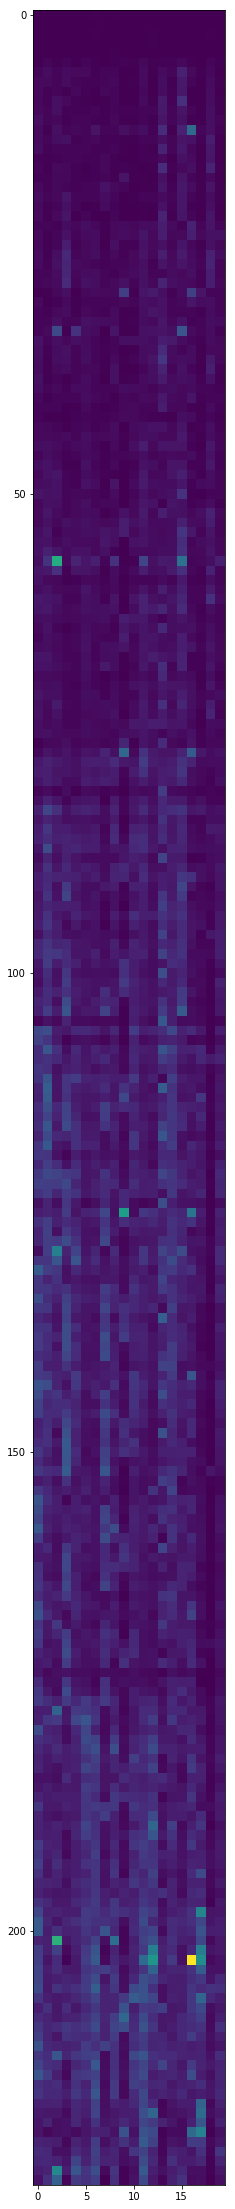

In [35]:
plt.figure(figsize=(10, 40))
plt.imshow(gb[topics])

## pygal

In [441]:
import pygal
from IPython.display import SVG, HTML

In [442]:
html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [ ]:
line_chart = pygal.StackedLine(fill=True, show_dots=False)
line_chart.title = 'Topics'
for topic in topics:
    line_chart.add(topic, gb[topic].values)
    
HTML(html_pygal.format(pygal_render=line_chart.render(is_unicode=True)))

In [444]:
line_chart.render_to_file(f'data/visualization/{name_dataset}_pygal.svg')

## joypy

In [445]:
import joypy # !pip install joypy

In [36]:
print(joined.shape)
joined.head()

(60849, 23)


,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,1999,10,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.324457,...,0.310229,0.133554,0.000000,0.031726,0.200034,0.000000,0.0,0.000000,0.000000,0.0
1,1,1999,10,0.017693,0.000000,0.242693,0.0,0.000000,0.145671,0.000000,...,0.000000,0.000000,0.107085,0.000000,0.000000,0.322927,0.0,0.000000,0.000000,0.0
2,2,1999,10,0.000000,0.282228,0.000000,0.0,0.028531,0.311935,0.217573,...,0.000000,0.048362,0.110676,0.000000,0.000695,0.000000,0.0,0.000000,0.000000,0.0
3,3,1999,10,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.068380,0.132985,0.000000,0.016713,0.000000,0.0,0.121322,0.561363,0.0
4,4,1999,12,0.000000,0.087762,0.000000,0.0,0.000000,0.236211,0.000000,...,0.106635,0.000000,0.262116,0.000000,0.272139,0.000000,0.0,0.000000,0.000000,0.0


In [39]:
joined.to_csv(f'./data/topicsProbability/{name_dataset}.csv',index=False)

In [447]:
joined['year_month'] = joined.apply(lambda x: str(int(x.year)) +'-'+ str(int(x.month)) + '-01', axis=1)
joined.reset_index(inplace=True)

joined.head()

,index,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,year_month
0,0,0,1999,10,0.000000,0.000000,0.000000,0.0,0.122868,0.000000,...,0.077717,0.000000,0.033593,0.239395,0.000000,0.0,0.000000,0.000000,0.01821,1999-10-01
1,1,1,1999,10,0.018509,0.000000,0.262834,0.0,0.000000,0.330809,...,0.000000,0.000000,0.000000,0.000000,0.194672,0.0,0.000000,0.000000,0.00000,1999-10-01
2,2,2,1999,10,0.000000,0.153630,0.000000,0.0,0.080671,0.045603,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.494366,0.000000,0.00000,1999-10-01
3,3,3,1999,10,0.000000,0.000000,0.000000,0.0,0.155428,0.000000,...,0.043140,0.137149,0.000000,0.033424,0.000000,0.0,0.000000,0.551085,0.00000,1999-10-01
4,4,4,1999,12,0.000000,0.109492,0.017353,0.0,0.000000,0.076010,...,0.000000,0.100906,0.000000,0.153172,0.000000,0.0,0.447607,0.000000,0.00000,1999-12-01


In [448]:
joined_melt = joined.melt('year_month', var_name='topic', value_name='text')
print(joined_melt.shape)
joined_melt.head()

(1460376, 3)


,year_month,topic,text
0,1999-10-01,index,0.0
1,1999-10-01,index,1.0
2,1999-10-01,index,2.0
3,1999-10-01,index,3.0
4,1999-12-01,index,4.0


In [449]:
# select only topic_*
joined_melt_new = joined_melt[(joined_melt.topic!='docID') & (joined_melt.topic!='index')
                              & (joined_melt.topic!='year') & (joined_melt.topic!='month')]
print(joined_melt_new.shape)
joined_melt_new.topic.value_counts()

(1216980, 3)


topic_14    60849
topic_18    60849
topic_8     60849
topic_13    60849
topic_6     60849
topic_15    60849
topic_7     60849
topic_0     60849
topic_16    60849
topic_4     60849
topic_19    60849
topic_1     60849
topic_5     60849
topic_3     60849
topic_9     60849
topic_2     60849
topic_10    60849
topic_11    60849
topic_17    60849
topic_12    60849
Name: topic, dtype: int64

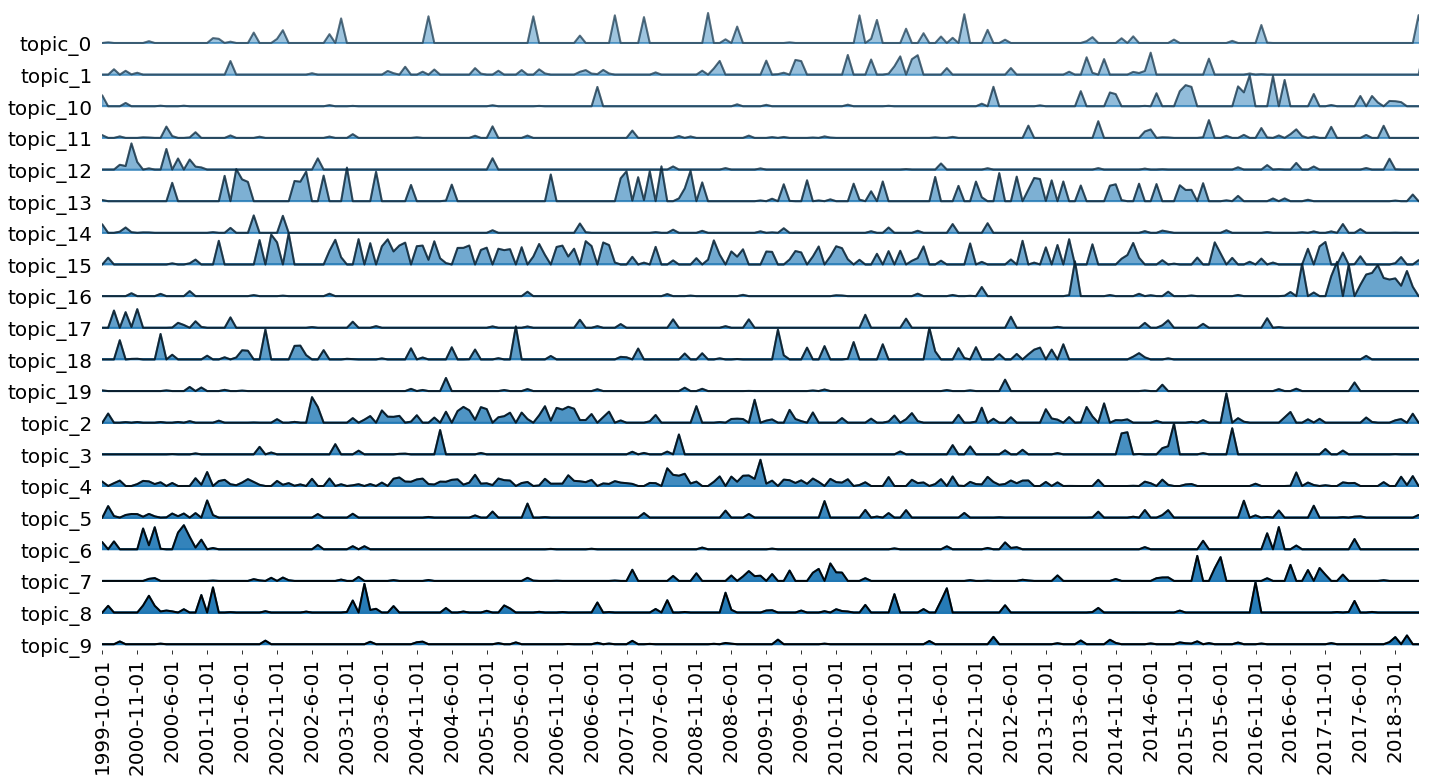

In [450]:
labels = sorted(joined_melt_new['year_month'].unique())

fig, axes = joypy.joyplot(joined_melt_new, by='topic', column='text', figsize=(20, 10),xlabelsize=20,ylabelsize=20,
                          overlap=0.4, fill=True, linecolor="k", linewidth=2,
                          kind='values', fade=True, xrot=90, x_range=[i for i in range(len(labels))],
                          background='white');

ticks_labels = {i:t for i, t in enumerate(labels)}
axes[-1].set_xticks([k for k, v in ticks_labels.items() if k % 6 == 0])
ticks = axes[-1].get_xticks()
axes[-1].set_xticklabels([ticks_labels.get(i, 'stop') for i in ticks]);

In [451]:
fig.savefig(f'data/visualization/{name_dataset}_joypy')